# <a id='toc1_'></a>[More about liabilities](#toc0_)
4th week, 2nd section, Introduction to Portfolio Construction and Analysis with Python.
Vijay Vaidyanathan & Lionel Martellini.  
Notes and code written by Benoît MARION.

**Table of contents**<a id='toc0_'></a>    
- [More about liabilities](#toc1_)    
  - [Lecture 1 - Choosing the policy portfolio](#toc1_1_)    
  - [Lecture 2 - Beyond LDI](#toc1_2_)    
  - [Lecture 3 - Liability-friendly equity portfolio](#toc1_3_)    
  - [Lab 1 - Monte Carlo simulations of coupon-bearing bonds using CIR](#toc1_4_)    
    - [Imports](#toc1_4_1_)    
    - [Computing bond price with changing interest rates](#toc1_4_2_)    
    - [Bond total return](#toc1_4_3_)    
    - [Portfolio with 2 investments:](#toc1_4_4_)    
  - [Lab 2 - Naive risk budgeting between the PSP & GHP](#toc1_5_)    
    - [Imports](#toc1_5_1_)    
    - [Backtester and fixed mixed allocator](#toc1_5_2_)    
    - [getting the returns for a fixed mixed portofolio (60% 10y, 40% 30y)](#toc1_5_3_)    
    - [getting the returns for a fixed mixed portofolio (70% eq, 30% bonds)](#toc1_5_4_)    
    - [Some news stats ^^](#toc1_5_5_)    
    - [Seaborn histplot](#toc1_5_6_)    
    - [Glide path (eq at the beginning and bonds at the end)](#toc1_5_7_)    
  - [Lab 3 - Dynamic risk budgeting between PSP & LHP](#toc1_6_)    
    - [Imports](#toc1_6_1_)    
    - [The issue with breaches](#toc1_6_2_)    
    - [Floor allocators](#toc1_6_3_)    
      - [Simple floor allocator](#toc1_6_3_1_)    
      - [Max-drawdown floor allocator](#toc1_6_3_2_)    
    - [Plot all results](#toc1_6_4_)    
    - [Drawdown constraints with historical data](#toc1_6_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Lecture 1 - Choosing the policy portfolio](#toc0_)

Liability driven investing suggest to hold 2 portfolios: one to achieve best returns and the other to match the future liabilities, but how to allocate between those 2 ?  
Often the allocation is defined by a $ \gamma $ parameter which is a risk aversion parameter. This $ \gamma $ is however hard to define as the two objectives are contradictory: it is a trade-oof between investment and risk budget.

## <a id='toc1_2_'></a>[Lecture 2 - Beyond LDI](#toc0_)

LDI supposes that each portfolio should only aim at getting the best results for each objective. However in many cases there can be interactions between those two.  
As a consequence, strong benefits can be expected from improving hedging characteristics of the PSP without impacting the performance of it. In that case, the investor can invest more money in PSP and less in the LHP.

## <a id='toc1_3_'></a>[Lecture 3 - Liability-friendly equity portfolio](#toc0_)

How to built a portfolio composed of equities that hedges better liabilities?  
- high dividend stocks
- low volatility stocks are often the closest to bonds (factor matching)    
  
Overall, selecting stocks with above average liability friendliness allows investors to put more into the PSP, often achieving better performance.

## <a id='toc1_4_'></a>[Lab 1 - Monte Carlo simulations of coupon-bearing bonds using CIR](#toc0_)

### <a id='toc1_4_1_'></a>[Imports](#toc0_)

In [1]:
import add_doc_path
import finance_pkg.Edhec_risk_kit as erk
import pandas as pd 
import numpy as np

### <a id='toc1_4_2_'></a>[Computing bond price with changing interest rates](#toc0_)

In [2]:
rates, zc_prices=erk.cir(10,500,b=.03,r_0=.03)

<AxesSubplot: >

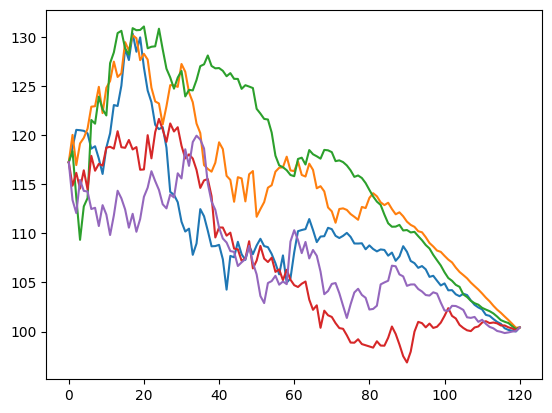

In [5]:
erk.bond_price(10,100,.05,12,rates[[1,2,3,4,5]]).plot(legend=False)

### <a id='toc1_4_3_'></a>[Bond total return](#toc0_)

In [6]:
p=erk.bond_price(10,100,.05,12,rates[[1,2,3,4]])
btr=erk.bond_total_return(p,100,.05,12)
erk.annualize_rets(btr,12)

1    0.029685
2    0.030241
3    0.028669
4    0.030059
dtype: object

In [12]:
mean_rets_bond=rets_10.mean(axis='columns')
erk.summary_stats(pd.DataFrame(mean_rets_bond))

,Annualized Return,Annualized Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.031805,0.002351,2.49117,13.587577,-0.002203,-0.001658,0.747044,0.0


### <a id='toc1_4_4_'></a>[Portfolio with 2 investments:](#toc0_)

In [14]:
price_eq=erk.gbm(n_years=10,n_scenarios=500, mu=.07,sigma=.15)
rets_eq=price_eq.pct_change().dropna()
rets=.7*rets_eq+.3*rets_bonds
erk.summary_stats(pd.DataFrame(rets.mean(axis='columns')))

,Annualized Return,Annualized Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.059915,0.004574,-0.461715,3.47836,-0.002544,-0.001674,6.365855,0.0


## <a id='toc1_5_'></a>[Lab 2 - Naive risk budgeting between the PSP & GHP](#toc0_)

### <a id='toc1_5_1_'></a>[Imports](#toc0_)

In [18]:
import pandas as pd
import numpy as np
import add_doc_path
import finance_pkg.Edhec_risk_kit as erk
import seaborn as sns
import matplotlib.pyplot as plt

### <a id='toc1_5_2_'></a>[Backtester and fixed mixed allocator](#toc0_)

In [2]:
def bt_mix(r1,r2,allocator,**kwargs):
    """Runs a backtest (simulation) of allocating between 2 sets of returns
    Args:
        r1 (pd.DataFrame): TxN df of retruns where t is time step index and N the number of scenarios.
        r2 (pd.DataFrame): same as above
        allocator (_type_): function that rakes the 2 sets and allocator specific params and returns allocation 
                            to the first (the one to the second portfolio is the reste)
        Returns:
            a TxN df of the N portfolio scenarios
    """
    if not r1.shape==r2.shape:
        raise ValueError("r1 and r2 need to be the same shape")
    weights=allocator(r1,r2,**kwargs)
    if not weights.shape==r1.shape:
        raise ValueError("alloc wieghts do not match r1") 
    r_mix=weights*r1+(1-weights)*r2
    return r_mix

In [3]:
def fixedmix_allocator(r1,r2,w1,**kwargs):
    """Produces a time serios over T steps of allocations between the PSP and GHP accross N scenarios
    PSP and GHP are TxN df that represent the returns of the PSP and GHP such that=
    Args:
        r1 (pd.DataFrame): TxN df that represent the returns of the PSP or GHP 
        r2 (pd.DataFrame): TxN df that represent the returns of the PSP or GHP 
        w1 (_type_): _description_
    Returns:
        a TxN df of the PSP weights (no computations, weights are declared in the function)
    """
    return pd.DataFrame(data=w1,index=r1.index,columns=r1.columns)

### <a id='toc1_5_3_'></a>[getting the returns for a fixed mixed portofolio (60% 10y, 40% 30y)](#toc0_)

In [2]:
rates,zc_prices=erk.cir(10,500,b=.03,r_0=.03)
price_10=erk.bond_price(10,100,.05,12,rates)
price_30=erk.bond_price(30,100,.05,12,rates)
rets_10=erk.bond_total_return(price_10,100,.05,12)
rets_30=erk.bond_total_return(price_30,100,.05,12)

In [3]:
rets_bonds=erk.bt_mix(rets_10,rets_30,allocator=erk.fixedmix_allocator,w1=.6)
mean_rets_bond=rets_bonds.mean(axis='columns')
erk.summary_stats(pd.DataFrame(mean_rets_bond))

,Annualized Return,Annualized Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.035535,0.003694,0.385433,3.830816,-0.001305,-0.000841,1.458393,-0.000193


### <a id='toc1_5_4_'></a>[getting the returns for a fixed mixed portofolio (70% eq, 30% bonds)](#toc0_)

In [6]:
price_eq=erk.gbm(n_scenarios=500)
rets_eq=price_eq.pct_change().dropna()
rets_zc=zc_prices.pct_change().dropna()

In [11]:
rets_70eq30b=erk.bt_mix(rets_eq,rets_bonds,allocator=erk.fixedmix_allocator,w1=.7)
mean_rets_70eq30b=rets_70eq30b.mean(axis='columns')
erk.summary_stats(pd.DataFrame(mean_rets_70eq30b))

,Annualized Return,Annualized Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.060185,0.004942,0.120323,2.579087,-0.002583,-0.002239,5.944761,0.0


### <a id='toc1_5_5_'></a>[Some news stats ^^](#toc0_)

In [13]:
def terminal_values(rets):
    """return value of a dollar at the end of investment period
    Args:
        rets (pd.Series or pd.DataFrame): set of returns
    """
    return (rets+1).prod()

def terminal_stats(rets,floor=0.8,name="Stats",cap=np.inf):
    """
    Return a dataframe of statistics for a given input pd.DataFrame of asset returns 
    and a dollar investment. 
    Statistics computed are:
    - the mean terminal wealth (compounded return)
    - the mean terminal wealth volatility
    - the probability that an input floor is breached by terminal wealths
    - the expected shortfall of those terminal wealths breaching the input floor 
    - same stats about reaching the objective
    Args:
        rets (pd.DataFrame):set of returns
        floor and cap (float): targets for a dollar investment
    Returns:
        pd.DataFrame: set of stats
    """
    terminal_wealth = (rets+1).prod()  # terminal wealths over scenarios, i.e., compounded returns
    # boolean vector of terminal wealths going below the floor or above cap
    floor_breach=terminal_wealth < floor
    cap_reach=terminal_wealth>=cap
     # prob of breach and reach
    p_breach=floor_breach.mean() if floor_breach.sum() > 0 else 0 
    p_reach=cap_reach.mean() if cap_reach.sum() > 0 else 0
    # exp shortfall & surplus
    e_short=(floor - terminal_wealth[floor_breach]).mean() if floor_breach.sum() > 0 else np.nan
    e_surp=(cap - terminal_wealth[cap_reach]).mean() if cap_reach.sum() > 0 else np.nan

    sum_stats = pd.DataFrame.from_dict({
        "Mean wealth":     terminal_wealth.mean(),
        "Mean wealth std": terminal_wealth.std(),
        "Prob breach":     p_breach,
        "Exp shortfall":   e_short,
        "Prob reach":      p_reach,
        "Exp. surp":       e_surp,
                                        }, orient="index", columns=[name])
    return sum_stats

In [12]:
pd.concat([terminal_stats(rets_bonds,name="FI"),
           terminal_stats(rets_eq,name="EQ"),
           terminal_stats(rets_70eq30b,name="EQ70-FI30"),
           ],axis=1)

,FI,EQ,7030
Mean wealth,1.379611,1.981097,1.789051
Mean wealth std,0.111985,0.964760,0.602897
Prob breach,NaN,0.044000,0.018000
Exp shortfall,NaN,0.173313,0.094488
Prob reach,NaN,NaN,NaN
Exp. surp,NaN,NaN,NaN


### <a id='toc1_5_6_'></a>[Seaborn histplot](#toc0_)

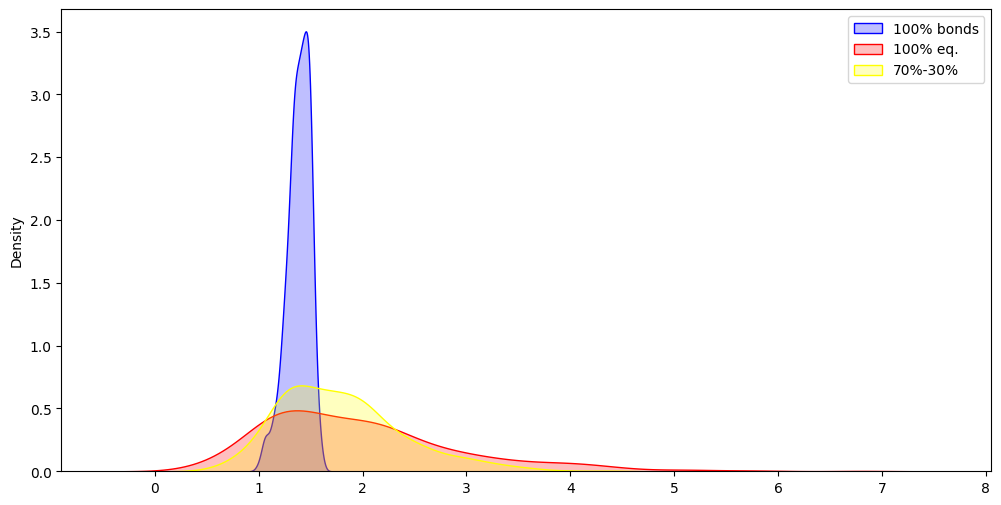

In [32]:
plt.figure(figsize=(12,6))
sns.kdeplot(terminal_values(rets_bonds),color='blue',label="100% bonds",fill=True)
sns.kdeplot(terminal_values(rets_eq),color='red',label="100% eq.",fill=True)
sns.kdeplot(terminal_values(rets_70eq30b),color='yellow',label="70%-30%",fill=True)
plt.legend();

### <a id='toc1_5_7_'></a>[Glide path (eq at the beginning and bonds at the end)](#toc0_)

In [33]:
def glidepath_allocator(r1,r2,start_glide=1,end_glide=0):
    """Simulation a gradual target-to-date move from asset r1 to asset r2
    Args:
        r1 (pd.DataFrame): set of returns
        r2 (pd.DataFrame): set of returns
        start_glide (int, optional): _description_. Defaults to 1.
        end_glide (int, optional): _description_. Defaults to 0.
    Returns:
        pd.DataFrame: n paths from start to end in a df
    """
    n_points=r1.shape[0]
    n_col=r1.shape[1]
    path=pd.Series(data=np.linspace(start_glide,end_glide,num=n_points))
    paths=pd.concat([path]*n_col,axis=1)
    paths.index=r1.index
    paths.columns=r1.columns
    return paths

In [35]:
rets_glide8020_eqb=erk.bt_mix(rets_eq,rets_bonds,allocator=glidepath_allocator,start_glide=.8,end_glide=.2)

In [36]:
pd.concat([terminal_stats(rets_bonds,name="FI"),
           terminal_stats(rets_eq,name="EQ"),
           terminal_stats(rets_70eq30b,name="EQ70-FI30"),
           terminal_stats(rets_glide8020_eqb,name="glide80/20 EQ to FI")
           ],axis=1)

,FI,EQ,EQ70-FI30,glide80/20 EQ to FI
Mean wealth,1.379611,1.981097,1.789051,1.667305
Mean wealth std,0.111985,0.964760,0.602897,0.445319
Prob breach,NaN,0.044000,0.018000,0.006000
Exp shortfall,NaN,0.173313,0.094488,0.064810
Prob reach,NaN,NaN,NaN,NaN
Exp. surp,NaN,NaN,NaN,NaN


## <a id='toc1_6_'></a>[Lab 3 - Dynamic risk budgeting between PSP & LHP](#toc0_)

### <a id='toc1_6_1_'></a>[Imports](#toc0_)

In [1]:
import numpy as np 
import pandas as pd
import add_doc_path
import finance_pkg.Edhec_risk_kit as erk
import matplotlib.pyplot as plt
import seaborn as sns

I created a small function to built the return table for different portfolios.

In [8]:
def concat_term_results(list_of_rets,floor=.80):
    list_of_stats=[]
    for rets in list_of_rets:
        nom =[x for x in globals() if globals()[x] is rets][0].split('_',1)[1]
        list_of_stats.append(erk.terminal_stats(rets,floor=floor,name=nom))
    return pd.concat(list_of_stats,axis=1).round(3)

### <a id='toc1_6_2_'></a>[The issue with breaches](#toc0_)

In [2]:
n_scenarios=5000
rates,zc_prices=erk.cir(10,n_scenarios=n_scenarios,b=.03,r_0=.03,sigma=.02)
price_eq=erk.gbm(n_years=10,n_scenarios=n_scenarios,mu=.07,sigma=.15)

In [10]:
rets_eq=price_eq.pct_change().dropna()
rets_zc=zc_prices.pct_change().dropna()
rets_70eq_30zc=erk.bt_mix(rets_eq,rets_zc,allocator=erk.fixedmix_allocator,w1=.7)
concat_term_results([rets_zc,rets_eq,rets_70eq_30zc])

,zc,eq,70eq_30zc
Mean wealth,1.343,1.962,1.752
Mean wealth std,0.000,0.983,0.593
Prob breach,0.000,0.049,0.015
Exp shortfall,NaN,0.135,0.086
Prob reach,0.000,0.000,0.000
Exp. surp,NaN,NaN,NaN


As we can see our portfolios sometimes fall below the floor (breach). We need to have a strategy to maximize returns while avoiding these breaches.

### <a id='toc1_6_3_'></a>[Floor allocators](#toc0_)

#### <a id='toc1_6_3_1_'></a>[Simple floor allocator](#toc0_)

In [11]:
def floor_allocator(psp_rets, lhp_rets, zc_prices, floor, m=3):
    """Allocate weights to PSP and LHP with the goal to provide exposure to the upside 
    of the PSP without going violating the floor. 
    The method uses a CPPI-style dynamic risk budgeting algorithm by investing a multiple 
    of a cushion in the PSP.
    Args:
        psp_rets (pd.DataFrame): performance seeking portfolio returns
        lhp_rets (pd.DataFrame): liability hedged portfolio returns
        zc_price (pd.DataFrame): price of the zero coupon bond
        floor (float): number you dont want to be below
        m (int, optional): multiplicator. Defaults to 3.
    Returns:
        pd.DataFrame: df containing the weights in the PSP 
    """
    if not zc_prices.shape == psp_rets.shape:
        raise ValueError("PSP rets and ZC prices must have the same shape")
    
    n_steps, n_scenarios = psp_rets.shape
    account_value  = np.repeat(1,n_scenarios)
    floor_value    = np.repeat(1,n_scenarios)
    w_history = pd.DataFrame(index=psp_rets.index, columns=psp_rets.columns)
    for step in range(n_steps):
        floor_value = floor * zc_prices.iloc[step]
        cushion = (account_value - floor_value) / account_value
        # weights in the PSP and LHP 
        psp_w = (m * cushion).clip(0,1)
        lhp_w = 1 - psp_w
        # update
        account_value = psp_w*account_value*(1 + psp_rets.iloc[step]) + lhp_w*account_value*(1 + lhp_rets.iloc[step])
        w_history.iloc[step] = psp_w
    return w_history

In [13]:
rets_floor75=erk.bt_mix(rets_eq,rets_zc,allocator=floor_allocator,floor=.75,zc_prices=zc_prices[1:],m=5)
concat_term_results([rets_zc,rets_eq,rets_70eq_30zc,rets_floor75],floor=.75)

,zc,eq,70eq_30zc,floor75
Mean wealth,1.343,1.962,1.752,1.949
Mean wealth std,0.000,0.983,0.593,0.990
Prob breach,0.000,0.036,0.009,0.000
Exp shortfall,NaN,0.126,0.074,0.001
Prob reach,0.000,0.000,0.000,0.000
Exp. surp,NaN,NaN,NaN,NaN


#### <a id='toc1_6_3_2_'></a>[Max-drawdown floor allocator](#toc0_)

In [14]:
def drawdown_allocator(psp_rets,lhp_rets,maxdd=.3,m=3):
    """Allocate weights to PSP and LHP with the goal to provide exposure to the upside 
    of the PSP without going violating the floor. 
    The method uses a CPPI-style dynamic risk budgeting algorithm by investing a multiple 
    of a cushion in the PSP.
    The cushion is computed by using a floor value equal to (1-maxdd) times the current peak.
    Args:
        psp_rets (pd.DataFrame): performance seeking portfolio returns
        lhp_rets (pd.DataFrame): liability hedged portfolio returns
        maxdd (float): 0-1 maximum drawdown acceptable, used. Defaults to 0.3.
        m (int, optional): multiplicator. Defaults to 3.
    Returns:
        pd.DataFrame: df containing the weights in the PSP 
    """
    if not lhp_rets.shape==psp_rets.shape:
        raise ValueError("PSP rets and lhp rets must have the same shape")
    
    n_steps,n_scenarios=psp_rets.shape
    account_value=np.repeat(1,n_scenarios)
    floor_value=np.repeat(1,n_scenarios)
    peak_value=np.repeat(1,n_scenarios)
    w_history=pd.DataFrame(index=psp_rets.index, columns=psp_rets.columns)
    for step in range(n_steps):
        floor_value=(1-maxdd)*peak_value
        cushion=(account_value-floor_value)/account_value
        # weights in the PSP and LHP 
        psp_w=(m*cushion).clip(0,1)
        lhp_w=1-psp_w
        # update
        account_value=psp_w*account_value*(1+psp_rets.iloc[step])+lhp_w*account_value*(1+lhp_rets.iloc[step])
        peak_value=np.maximum(peak_value,account_value)
        w_history.iloc[step] = psp_w
    return w_history

In [16]:
cashrate=.02
monthly_cashreturn=(1+cashrate)**(1/12)-1
rets_cash=pd.DataFrame(data=monthly_cashreturn,index=rets_eq.index,columns=rets_eq.columns)
rets_maxdd25=erk.bt_mix(rets_eq,rets_cash,allocator=drawdown_allocator,maxdd=.25)

In [17]:
concat_term_results([rets_zc,rets_eq,rets_70eq_30zc,rets_floor75,rets_maxdd25],floor=.75)

,zc,eq,70eq_30zc,floor75,maxdd25
Mean wealth,1.343,1.962,1.752,1.949,1.625
Mean wealth std,0.000,0.983,0.593,0.990,0.541
Prob breach,0.000,0.036,0.009,0.000,0.000
Exp shortfall,NaN,0.126,0.074,0.001,NaN
Prob reach,0.000,0.000,0.000,0.000,0.000
Exp. surp,NaN,NaN,NaN,NaN,NaN


In [20]:
erk.summary_stats(rets_maxdd25)["Max Drawdown"].min()

-0.23278132923366346

### <a id='toc1_6_4_'></a>[Plot all results](#toc0_)

In [21]:
tv_eq=erk.terminal_values(rets_eq)
tv_zc=erk.terminal_values(rets_zc)
tv_70eq_30zc=erk.terminal_values(rets_70eq_30zc)
tv_floor75=erk.terminal_values(rets_floor75)
tv_maxdd25=erk.terminal_values(rets_maxdd25)

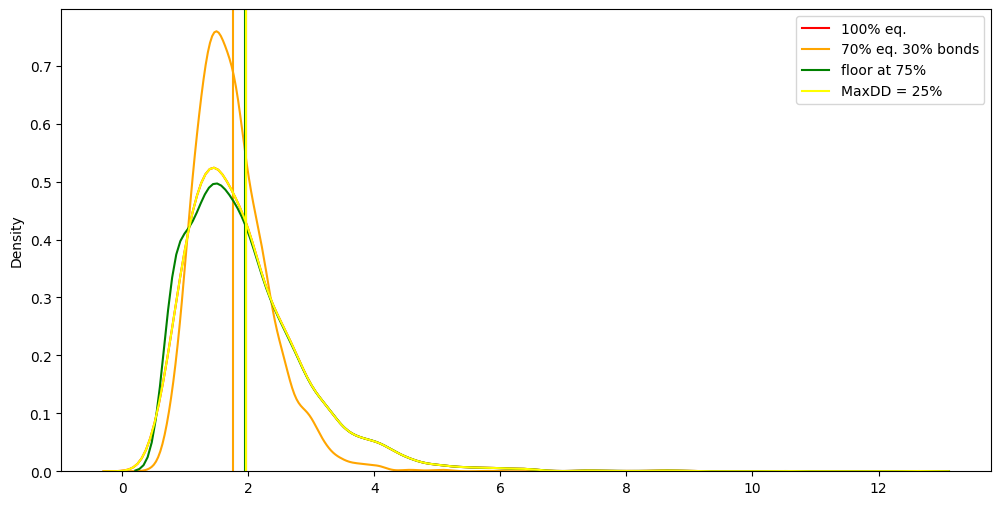

In [29]:
plt.figure(figsize=(12,6))
sns.kdeplot(tv_eq,color="red",label="100% eq.")
plt.axvline(tv_eq.mean(),ls="-",color="red")
sns.kdeplot(tv_70eq_30zc,color="orange",label="70% eq. 30% bonds")
plt.axvline(tv_70eq_30zc.mean(),ls="-",color="orange")
sns.kdeplot(tv_floor75,color="green",label="floor at 75%")
plt.axvline(tv_floor75.mean(),ls="-",color="green")
sns.kdeplot(tv_eq,color="yellow",label="MaxDD = 25%")
plt.axvline(tv_eq.mean(),ls="-",color="yellow")
plt.legend();

### <a id='toc1_6_5_'></a>[Drawdown constraints with historical data](#toc0_)

<AxesSubplot: >

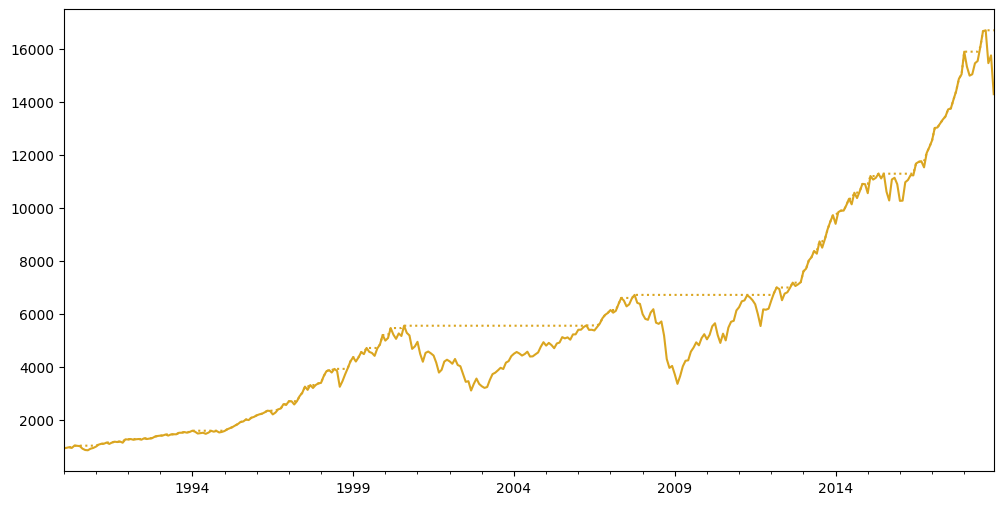

In [36]:
rets_tmi=erk.get_total_market_index_returns()["1990":]
dd_tmi=erk.drawdowns(rets_tmi)
ax=dd_tmi['wealth_index'].plot(figsize=(12,6),color='goldenrod',ls='-')
dd_tmi['peaks'].plot(ax=ax,color='goldenrod',ls=':')

In [43]:
cashrate=.03
monthly_cashreturn=(1+cashrate)**(1/12)-1
rets_cash=pd.DataFrame(data=monthly_cashreturn,index=rets_tmi.index,columns=[0])
rets_maxdd25=erk.bt_mix(pd.DataFrame(rets_tmi),rets_cash,allocator=drawdown_allocator,maxdd=.25,m=5)
dd_25=erk.drawdowns(rets_maxdd25[0])

<AxesSubplot: >

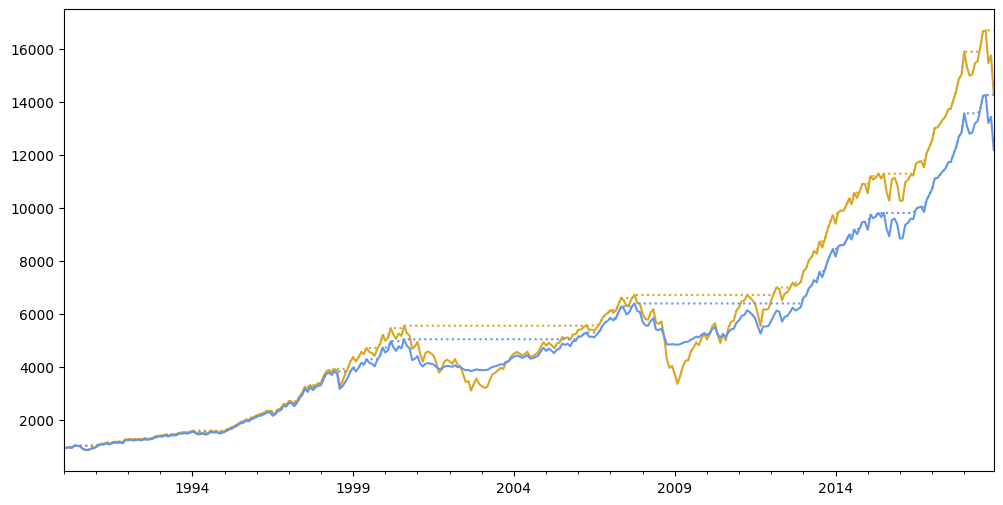

In [44]:
ax=dd_tmi['wealth_index'].plot(figsize=(12,6),color='goldenrod',ls='-')
dd_tmi['peaks'].plot(ax=ax,color='goldenrod',ls=':')
dd_25['wealth_index'].plot(ax=ax,color='cornflowerblue',ls='-')
dd_25['peaks'].plot(ax=ax,color='cornflowerblue',ls=':')

In [49]:
erk.summary_stats(pd.concat([rets_maxdd25[0].rename('maxDD portfolio'),r
                             ets_tmi.rename("Market")],axis=1))

,Annualized Return,Annualized Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
maxDD portfolio,0.090062,0.112755,-0.630463,5.015334,0.049978,0.071074,0.518327,-0.244212
Market,0.096058,0.145419,-0.668827,4.247282,0.066949,0.094633,0.441951,-0.499943
